Name: Sudhina D

Batch: R3

Date: 17-04-2023

Experiment Name: GAN - for Data augmentation for Image Classification

# GANs on Fashion MNIST Dataset

# Generative Adverserial Networks
Generative adversarial networks (GANs) are algorithmic architectures that use two neural networks, pitting one against the other (thus the “adversarial”) in order to generate new, synthetic instances of data that can pass for real data. They are used widely in image generation, video generation and voice generation.

While most deep generative models are trained by maximizing log likelihood or a lower bound on log likelihood, GANs take a radically different approach that does not require inference or explicit calculation of the data likelihood. Instead, two models are used to solve a minimax game: a generator which samples data, and a discriminator which classifies the data as real or generated.In theory these models are capable of modeling an arbitrarily complex probability distribution.

In practice, however, GANs suffer from many issues, particularly during training. One common failure mode involves the generator collapsing to produce only a single sample or a small family of very similar samples. In this case, the generator learns to trick the discriminator with a single image or a few images to believe as real image. Another involves the generator and discriminator oscillating during training,rather than converging to a fixed point. In addition, if one agent becomes much more powerful than the other, the learning signal to the other agent becomes useless, and the system does not learn. To train GANs many tricks must be employed,one such method is using Deep Convolution Generative Adversarial Networks.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


In [2]:
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
train_data = pd.read_csv('/content/gdrive/MyDrive/DNNSP LAB/fashion-mnist_test.csv.zip')
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


dropping the labels from the dataset

In [5]:
X_train = train_data.drop('label',axis=1)
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,9,8,0,...,103,87,56,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,0,63,53,31,0,0,0
3,0,0,0,0,0,0,0,0,0,161,...,137,126,140,0,133,224,222,56,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X_train=X_train.values
print(X_train.shape)

(10000, 784)


In [7]:
X_train=X_train.reshape(-1,28,28,1)
print(X_train.shape)

(10000, 28, 28, 1)


## Data Visualization

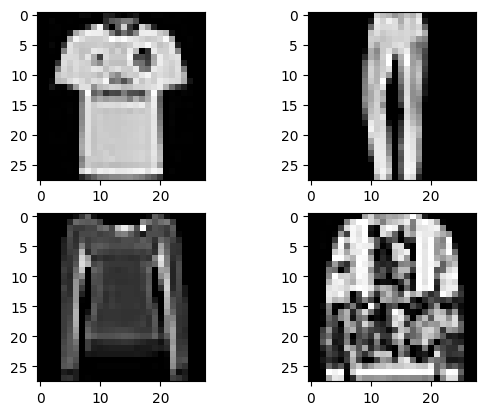

In [8]:
fig,axe=plt.subplots(2,2)
idx = 0
for i in range(2):
    for j in range(2):
        axe[i,j].imshow(X_train[idx].reshape(28,28),cmap='gray')
        idx+=1

In [9]:
X_train =  X_train.astype('float32')

The pixel data ranges from 0 to 255 hence dividing each pixel by 255,i.e,normalizing the data such that the range is within 0 to 1.

In [10]:
X_train = X_train/255
X_train = X_train*2 - 1.

NOTE: after normalizing it is multiplied with 2 and substracted from 1 such that it ranges from (-1,1) because in DCGANs the last layer generative model activation is tanh which range is (-1,1) unlike sigmoid ranging (0,1) .

In [11]:
print(X_train.max(),X_train.min())

1.0 -1.0


## Simple GAN Model

Generative part

In [12]:
generator = Sequential()
generator.add(Dense(512,input_shape=[100]))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(128))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(784))
generator.add(Reshape([28,28,1]))

In [13]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

Discriminatory part

In [14]:
discriminator = Sequential()
discriminator.add(Dense(1,input_shape=[28,28,1]))
discriminator.add(Flatten())
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))

In [15]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 28, 28, 1)         2         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               200960    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128)              

1. Compiling the discriminator layer
2. Compiling the GAN

NOTE : the generator layer is not compiled seperately because it gets trained as part of the combined model but training the discriminator is necessary because it is trained before the combined model.

In [16]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [17]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [18]:
GAN.layers

In [19]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         320656    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 242179    
                                                                 
Total params: 562,835
Trainable params: 318,864
Non-trainable params: 243,971
_________________________________________________________________


In [20]:
epochs = 30
batch_size = 100
noise_shape=100

Currently on Epoch 1
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [==============================] - 0s 114ms/step


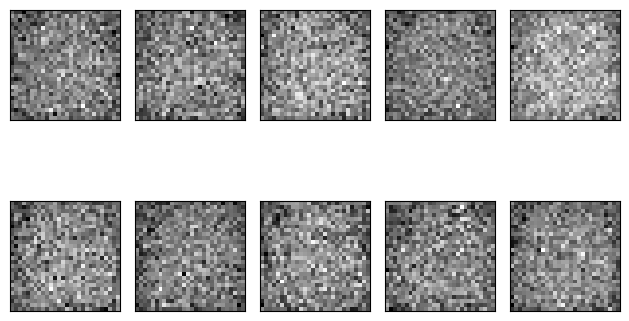

Currently on Epoch 2
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 3
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 4
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 5
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 6
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 7
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 8
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 9
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 10
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 11
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [==============================] -

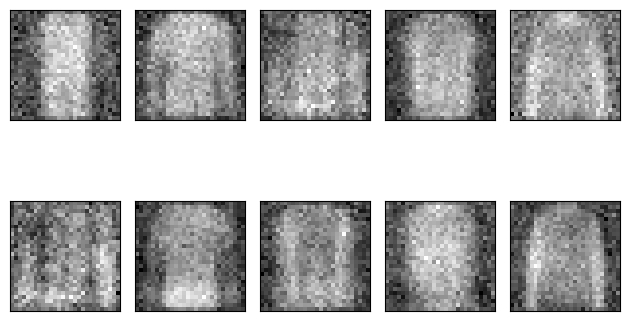

Currently on Epoch 12
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 13
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 14
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 15
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 16
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 17
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 18
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 19
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 20
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 21
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [=========================

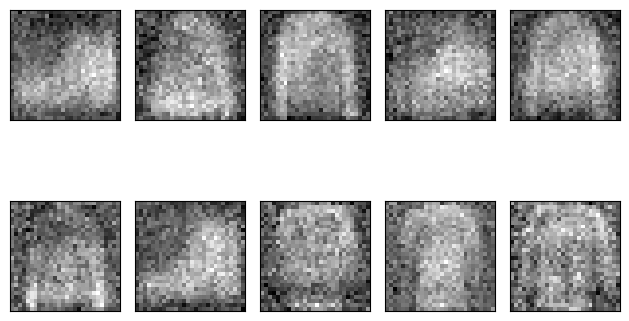

Currently on Epoch 22
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 23
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 24
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 25
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 26
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 27
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 28
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 29
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 30
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Training is complete


In [21]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    
    for i in range(X_train.shape[0]//batch_size):
        
        if (i+1)%50 == 0:
            print(f"\tCurrently on batch number {i+1} of {X_train.shape[0]//batch_size}")
            
        noise=np.random.normal(size=[batch_size,noise_shape])
       
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
       
        #training discriminator on real images
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss_real=discriminator.train_on_batch(train_dataset,train_label)
        
        #training discriminator on fake images
        train_label=np.zeros(shape=(batch_size,1))
        d_loss_fake=discriminator.train_on_batch(gen_image,train_label)
        
        
        #training generator 
        noise=np.random.normal(size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False
        
        d_g_loss_batch =GAN.train_on_batch(noise, train_label)
        
        
        
       
    #plotting generated images at the start and then after every 10 epoch
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

        
        
print('Training is complete')


In [22]:
noise=np.random.normal(size=[10,noise_shape])

gen_image = generator.predict(noise)

1/1 [==============================] - 0s 20ms/step


noise generated using np.random.normal is given to as input to the generator. In the next step the generator produces batches of meaningful alike image from the random distribution.

Text(0.5, 1.0, 'How the noise looks')

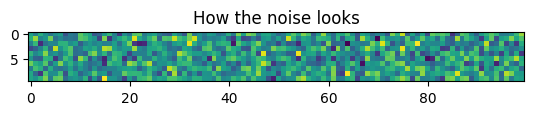

In [23]:
plt.imshow(noise)
plt.title('How the noise looks')

Generator producing images from noise


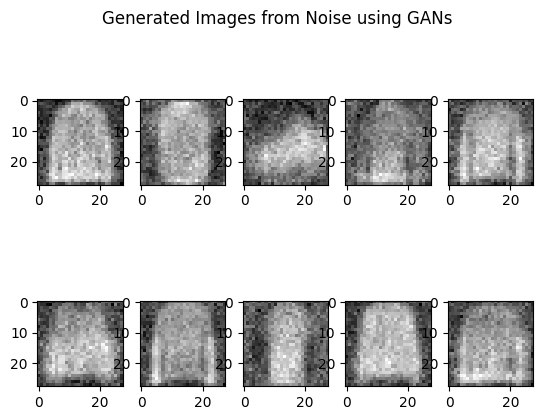

In [24]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using GANs')
idx=0
for i in range(2):
    for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=1

Inference from generated images

As discussed before after iterating through few tens of epochs the generator learns to trick the discriminator with only one specific category of output image and hence stops learning beyond that point. The ouput after complete training is thus only single type of images almost similar in features ,i.e, shirts in this particular case and there is no variation in generated image features.

The above issue can be resolved using DCGANs as given below.

# GAN using Deep Convolutions

In this model we construct the generator using transpose convolution layers instead of simple dense layers which helps better in feature capturing and prevents the issue as described earlier. Similarly while building the discriminator layer,instead of simple dense units it uses convolution layers to increase efficiency of it's classification.

In [25]:
generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[100]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))

In [26]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_3 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

In [27]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

In [28]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_10 (Dense)            (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 212,865
Non-tr

In [29]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [30]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [31]:
GAN.layers

In [32]:
GAN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 28, 28, 1)         840705    
                                                                 
 sequential_4 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


In [33]:
epochs = 150 #vary epoch size as per required to train the model
batch_size = 100

In [34]:
noise_shape=100

Currently on Epoch 1
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [==============================] - 0s 139ms/step


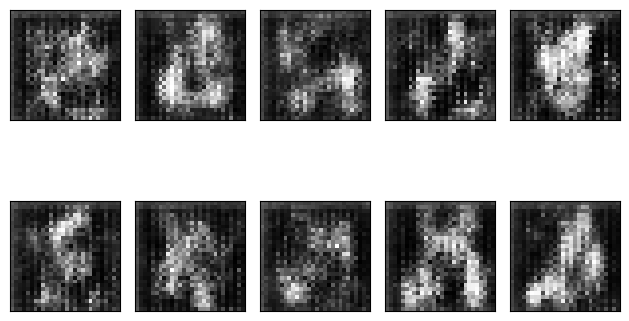

Currently on Epoch 2
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 3
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 4
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 5
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 6
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 7
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 8
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 9
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 10
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 11
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [==============================] -

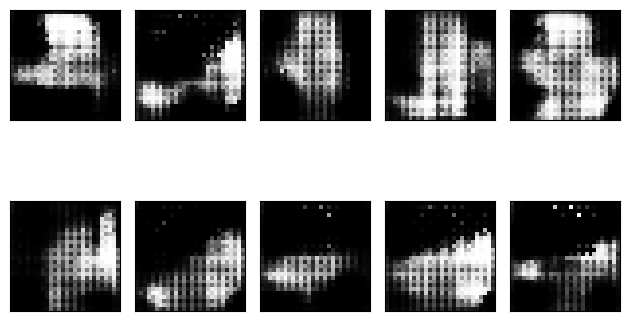

Currently on Epoch 12
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 13
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 14
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 15
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 16
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 17
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 18
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 19
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 20
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 21
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [=========================

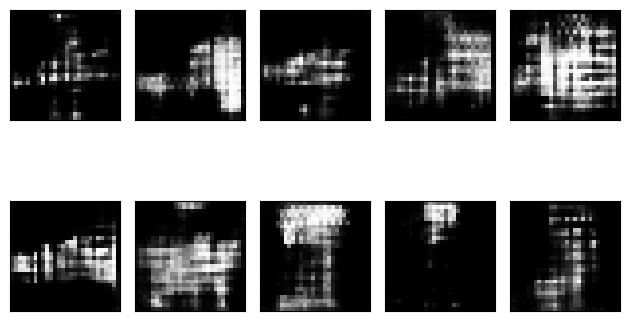

Currently on Epoch 22
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 23
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 24
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 25
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 26
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 27
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 28
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 29
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 30
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 31
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [=========================

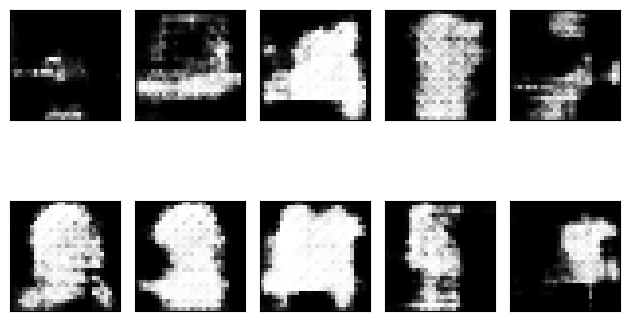

Currently on Epoch 32
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 33
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 34
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 35
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 36
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 37
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 38
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 39
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 40
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 41
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [=========================

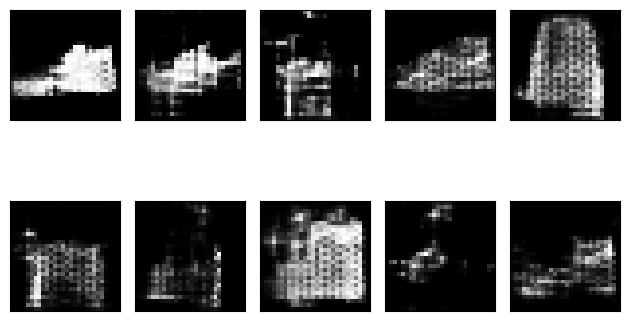

Currently on Epoch 42
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 43
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 44
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 45
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 46
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 47
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 48
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 49
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 50
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 51
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [=========================

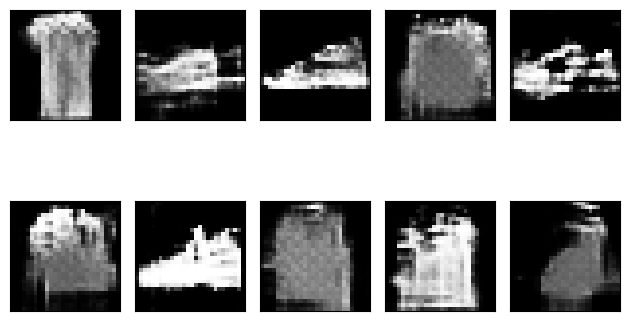

Currently on Epoch 52
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 53
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 54
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 55
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 56
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 57
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 58
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 59
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 60
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 61
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [=========================

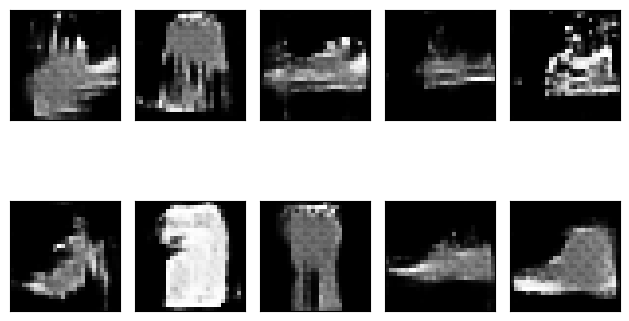

Currently on Epoch 62
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 63
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 64
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 65
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 66
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 67
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 68
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 69
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 70
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 71
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [=========================

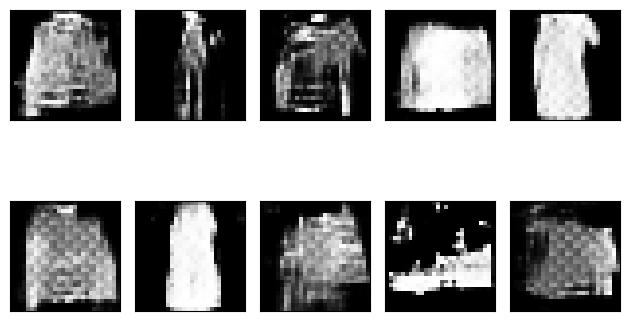

Currently on Epoch 72
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 73
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 74
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 75
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 76
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 77
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 78
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 79
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 80
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 81
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [=========================

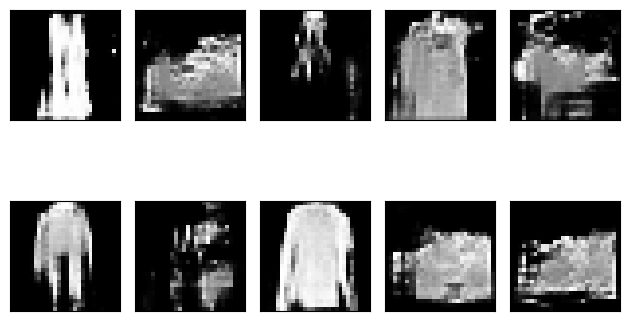

Currently on Epoch 82
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 83
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 84
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 85
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 86
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 87
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 88
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 89
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 90
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 91
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [=========================

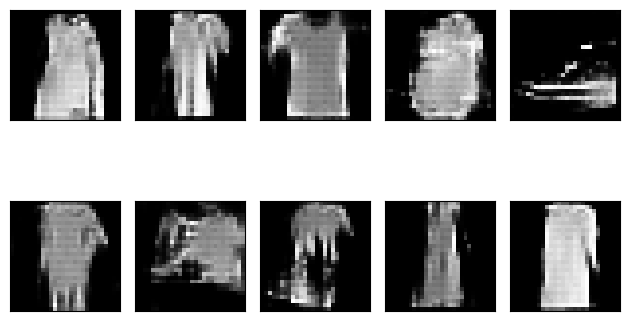

Currently on Epoch 92
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 93
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 94
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 95
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 96
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 97
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 98
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 99
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 100
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 101
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [=======================

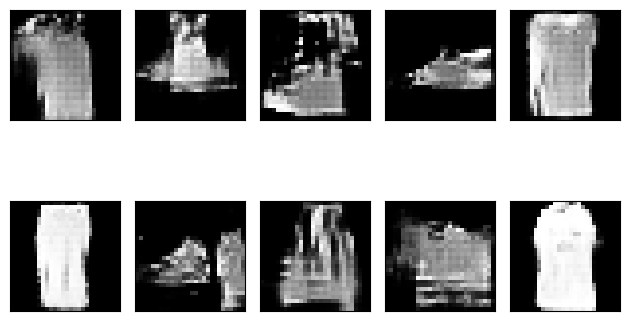

Currently on Epoch 102
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 103
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 104
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 105
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 106
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 107
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 108
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 109
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 110
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 111
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [===============

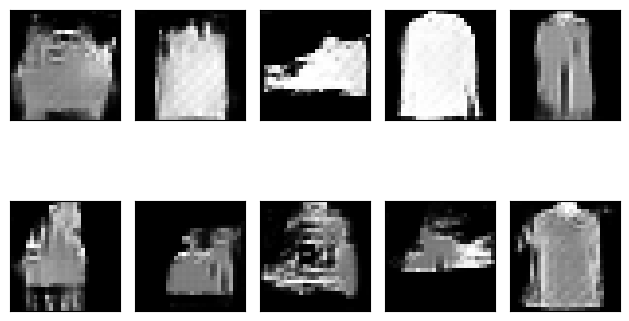

Currently on Epoch 112
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 113
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 114
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 115
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 116
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 117
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 118
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 119
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 120
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 121
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [===============

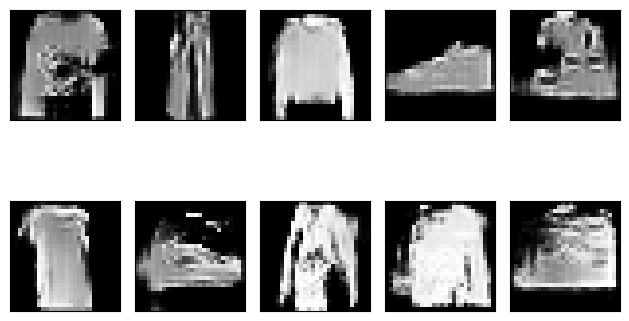

Currently on Epoch 122
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 123
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 124
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 125
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 126
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 127
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 128
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 129
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 130
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 131
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [===============

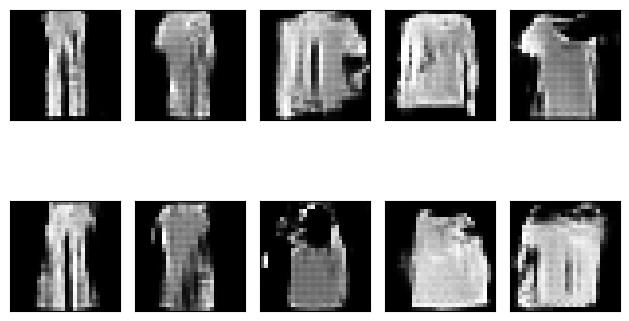

Currently on Epoch 132
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 133
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 134
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 135
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 136
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 137
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 138
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 139
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 140
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 141
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 [===============

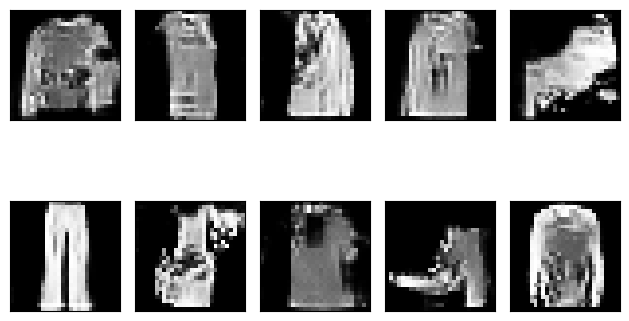

Currently on Epoch 142
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 143
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 144
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 145
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 146
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 147
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 148
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 149
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 150
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Training is complete


In [35]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    
    for i in range(X_train.shape[0]//batch_size):
        
        if (i+1)%50 == 0:
            print(f"\tCurrently on batch number {i+1} of {X_train.shape[0]//batch_size}")
            
        noise=np.random.normal(size=[batch_size,noise_shape])
       
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
       
        #training discriminator on real images
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss_real=discriminator.train_on_batch(train_dataset,train_label)
        
        #training discriminator on fake images
        train_label=np.zeros(shape=(batch_size,1))
        d_loss_fake=discriminator.train_on_batch(gen_image,train_label)
        
        
        #training generator 
        noise=np.random.normal(size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False #while training the generator as combined model,discriminator training should be turned off
        
        d_g_loss_batch =GAN.train_on_batch(noise, train_label)
        
        
        
       
    #plotting generated images at the start and then after every 10 epoch
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

        
        
print('Training is complete')


In [36]:
noise=np.random.normal(loc=0, scale=1, size=(100,noise_shape))

gen_image = generator.predict(noise)

4/4 [==============================] - 0s 16ms/step


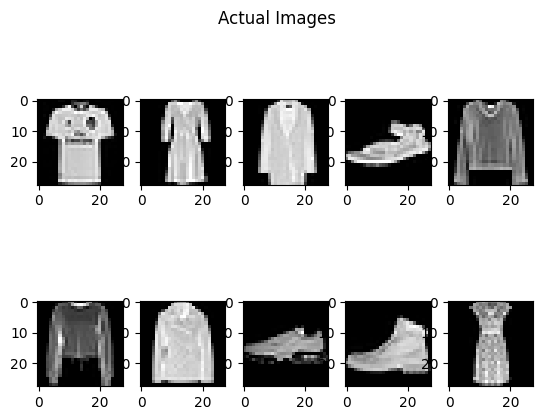

In [37]:
fig,axe=plt.subplots(2,5)
fig.suptitle("Actual Images")
idx = 0
for i in range(2):
    for j in range(5):
        axe[i,j].imshow(X_train[idx].reshape(28,28),cmap='gray')
        idx+=10

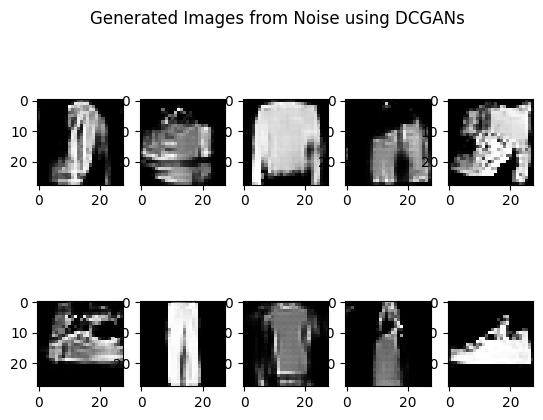

In [38]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using DCGANs')
idx=0
for i in range(2):
     for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=3

Inference

Introduction of deep convolution GAN helps in improving the variation in the output data and prevents the model from being stuck on single type of image. The interesting fact here seems that the generator being capable of creating meaningful images from noise inputs without even itself seeing the actual images and that's what makes GANS so interesting.